In [2]:
import sys, os, json, math, re, shapely
sys.path.append('backend/app/')
import xarray as xr, numpy as np, geopandas as gpd
import pandas as pd
from Functions import functions, gridFunctions
from scipy.interpolate import Rbf, griddata, interp1d
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.ndimage import distance_transform_edt, gaussian_filter
from meshkernel import MeshKernel, GeometryList

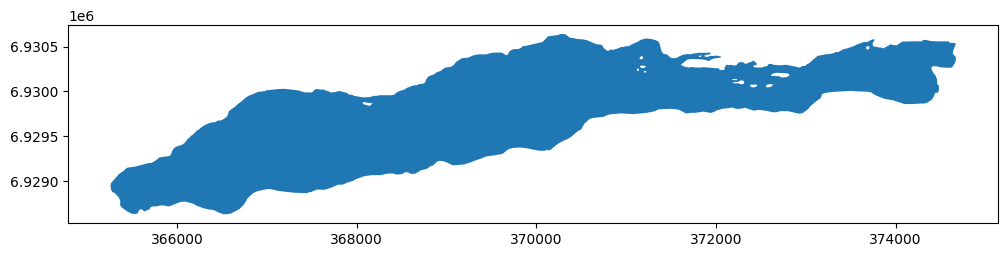

In [3]:
lake, depth = gpd.read_file('lake.geojson'), gpd.read_file('depth.geojson')
fig, ax = plt.subplots(figsize=(12, 10))
lake.plot(ax=ax)
plt.show()

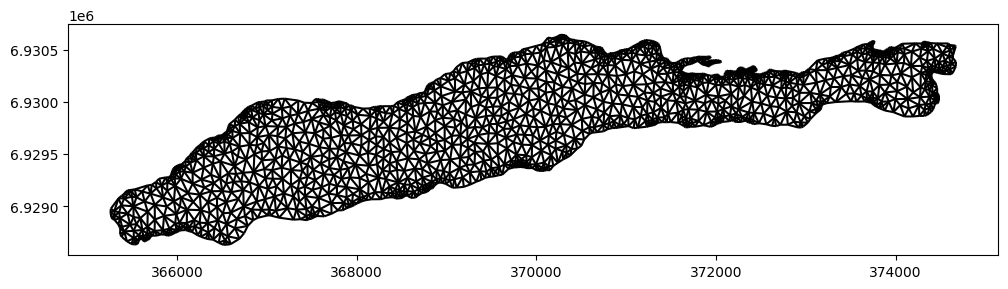

In [5]:
lake["geometry"] = lake.geometry.apply(lambda geo: gridFunctions.remove_holes(geo, 0))
x, y = lake.geometry.iloc[0].exterior.xy
x, y = np.array(x), np.array(y)
polygon = GeometryList(x, y)
mk = MeshKernel()
mk.mesh2d_make_triangular_mesh_from_polygon(polygon, scale_factor=10.5)
mesh = mk.mesh2d_get()
fig, ax = plt.subplots(figsize=(12, 3))
mesh.plot_edges(ax, color="black")
plt.show()

In [ ]:
mk.

In [12]:
mesh.edge_x

array([365508.5185664 , 365532.59529917, 365514.09500337, ...,
       374374.51848746, 374427.01931967, 374361.23193143])

In [6]:
grid_uds = gridFunctions.netCDF_creator(lake, depth)
# # Write to NetCDF
# grid_uds.to_netcdf("net.nc")
grid_uds

<xarray.Dataset> Size: 467kB
Dimensions:                      (mesh2d_nNodes: 1571, mesh2d_nEdges: 4118,
                                  Two: 2, mesh2d_nFaces: 2548,
                                  mesh2d_nMax_face_nodes: 4)
Coordinates:
    mesh2d_node_x                (mesh2d_nNodes) float64 13kB 3.704e+05 ... 3...
    mesh2d_node_y                (mesh2d_nNodes) float64 13kB 6.931e+06 ... 6...
  * mesh2d_nNodes                (mesh2d_nNodes) int64 13kB 0 1 2 ... 1569 1570
Dimensions without coordinates: mesh2d_nEdges, Two, mesh2d_nFaces,
                                mesh2d_nMax_face_nodes
Data variables:
    projected_coordinate_system  int32 4B -2147483647
    mesh2d                       int32 4B 0
    mesh2d_node_z                (mesh2d_nNodes) float64 13kB -10.0 ... -70.0
    mesh2d_edge_x                (mesh2d_nEdges) float64 33kB 3.655e+05 ... 3...
    mesh2d_edge_y                (mesh2d_nEdges) float64 33kB 6.929e+06 ... 6...
    mesh2d_edge_nodes            (mesh2d_nEdges, Two) int32 33kB 415 ... 194
    mesh2d_face_nodes            (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 82kB ...
    mesh2d_edge_faces            (mesh2d_nEdges, Two) int32 33kB 775 776 ... 362
    mesh2d_face_x                (mesh2d_nFaces) float64 20kB 3.703e+05 ... 3...
    mesh2d_face_y                (mesh2d_nFaces) float64 20kB 6.931e+06 ... 6...
    mesh2d_face_x_bnd            (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 82kB ...
    mesh2d_face_y_bnd            (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 82kB ...
Attributes:
    Conventions:  CF-1.9 UGRID-1.0
    institution:  Private
    references:   vanlnNTNU@gmail.com
    source:       Created with meshkernel 8.2.2, xugrid 0.14.3 and dfm_tools ...
    history:      Created on 2026-02-10T14:17:30, vanln

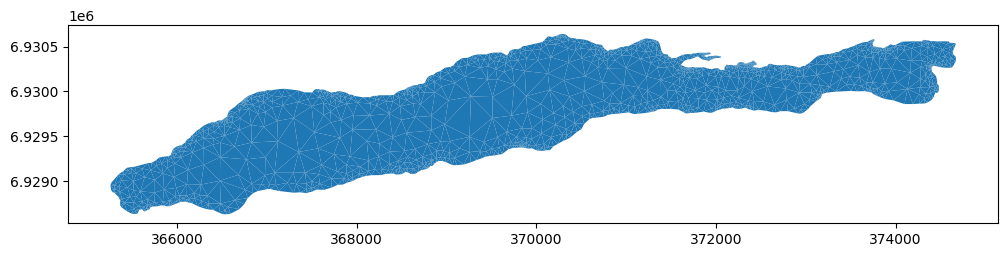

In [7]:
new_grid = functions.unstructuredGridCreator(grid_uds)
fig, ax = plt.subplots(figsize=(12, 8))
new_grid.to_crs(lake.crs).plot(ax=ax)
plt.show()

In [10]:
new_grid.to_crs(epsg=4326).to_file('grid.geojson', driver='GeoJSON')

In [11]:
data = xr.open_dataset(r'backend\static\samples\grid\Grid_net.nc')
data

<xarray.Dataset> Size: 919kB
Dimensions:            (mesh2d_nNodes: 2645, mesh2d_nEdges: 7579, Two: 2,
                        mesh2d_nFaces: 4935, mesh2d_nMax_face_nodes: 4)
Coordinates:
    mesh2d_node_x      (mesh2d_nNodes) float64 21kB ...
    mesh2d_node_y      (mesh2d_nNodes) float64 21kB ...
Dimensions without coordinates: mesh2d_nNodes, mesh2d_nEdges, Two,
                                mesh2d_nFaces, mesh2d_nMax_face_nodes
Data variables:
    wgs84              int32 4B ...
    mesh2d             int32 4B ...
    mesh2d_node_z      (mesh2d_nNodes) float64 21kB ...
    mesh2d_edge_x      (mesh2d_nEdges) float64 61kB ...
    mesh2d_edge_y      (mesh2d_nEdges) float64 61kB ...
    mesh2d_edge_nodes  (mesh2d_nEdges, Two) int32 61kB ...
    mesh2d_face_nodes  (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 158kB ...
    mesh2d_edge_faces  (mesh2d_nEdges, Two) float64 121kB ...
    mesh2d_face_x      (mesh2d_nFaces) float64 39kB ...
    mesh2d_face_y      (mesh2d_nFaces) float64 39kB ...
    mesh2d_face_x_bnd  (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 158kB ...
    mesh2d_face_y_bnd  (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 158kB ...
Attributes:
    institution:  Deltares
    references:   http://www.deltares.nl
    source:       RGFGRID 7.03.00.77422. Model: ---
    history:      Created on 2024-09-06T11:08:32+0200, RGFGRID
    Conventions:  CF-1.8 UGRID-1.0 Deltares-0.10

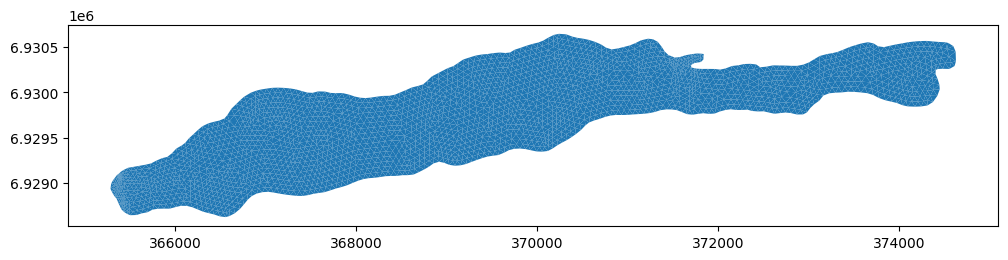

In [12]:
grid = functions.unstructuredGridCreator(data)
fig, ax = plt.subplots(figsize=(12, 8))
grid.to_crs(lake.crs).plot(ax=ax)
plt.show()

In [13]:
grid.to_crs(epsg=4326).to_file('grid_delft3d.geojson', driver='GeoJSON')